In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.21 GB, difference +0.21 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *
from db_dev.plotting import *

In [4]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [5]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [6]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [7]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [11]:

adata = adata[(adata.obs["sample"] == "UL")].copy()


/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


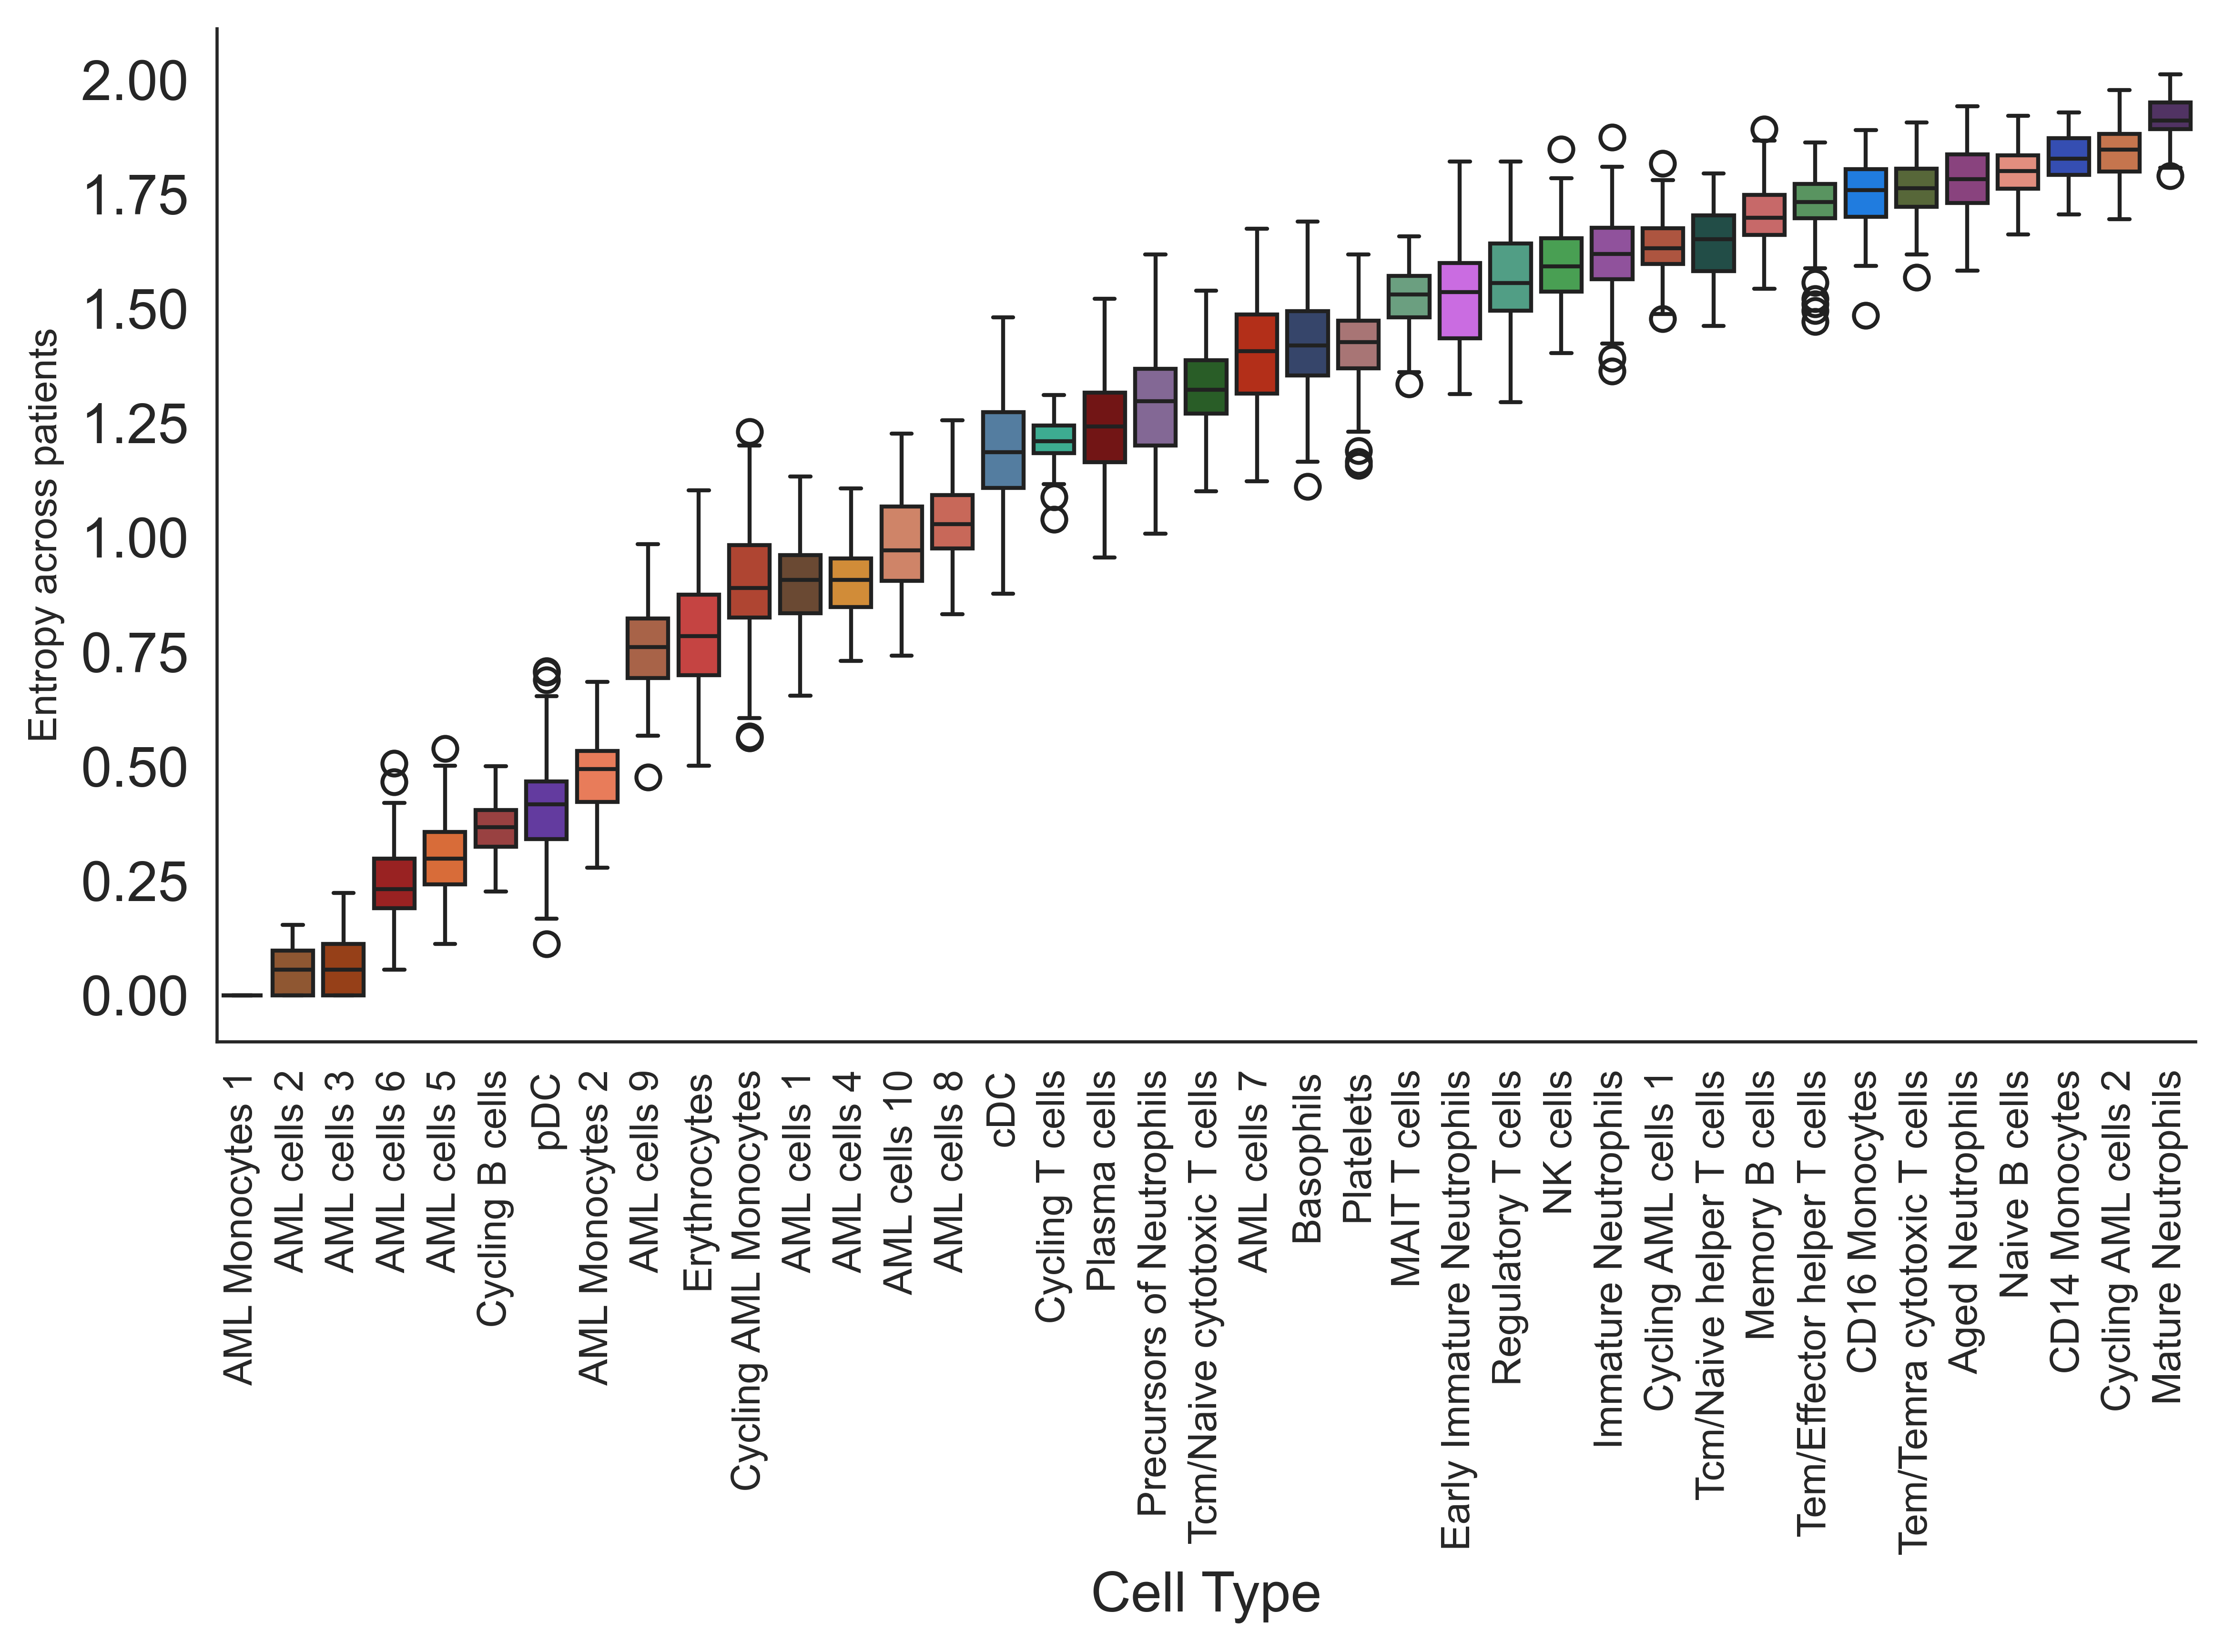

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PARAMETERS
ncells = 100  # number of cells to sample per cell type
nreps = 100   # number of repetitions for sampling
meta = 'cell_type_sub_prolif_anno'
sample_meta = 'code_renamed'

# EXTRACT UNIQUE CELL TYPES
cell_types = adata.obs[meta].unique()

# GENERATE COLORMAP
unique_cell_types = adata.obs[meta].unique()
colors = sns.color_palette("husl", len(unique_cell_types))
palette = dict(zip(unique_cell_types, colors))

# ENTROPY CALCULATION
H = pd.DataFrame()

for cell_type in cell_types:
    # SUBSET CELLS BY CELL TYPE
    cell_subset = adata[adata.obs[meta] == cell_type]

    H_sample = []

    for _ in range(nreps):
        # RANDOM SAMPLING
        sampled_cells = cell_subset[np.random.choice(cell_subset.shape[0], ncells, replace=True)]

        
        # COMPUTE PROBABILITIES
        labels = sampled_cells.obs[sample_meta]
        probs = labels.value_counts(normalize=True)
        
        # SHANNON ENTROPY
        entropy = -np.sum(probs * np.log(probs))
        H_sample.append(entropy)

    # STORE RESULTS
    H = pd.concat([H, pd.DataFrame({'Entropy across patients': H_sample, 'Cell Type': [cell_type] * nreps})], ignore_index=True)

# PLOT
plt.figure(figsize=(8, 6))
sns.set_style("white")
plot_order = H.groupby('Cell Type')['Entropy across patients'].mean().sort_values().index
sns.boxplot(x="Cell Type", y="Entropy across patients", hue = "Cell Type", data=H, palette=cell_type_color_palette, order=plot_order)
plt.ylabel("Entropy across patients", fontsize=10)
plt.xticks(rotation=90, fontsize=10)
sns.despine()

# SAVE FIGURE
plt.tight_layout()

plt.savefig("figures/final/patient_entropy_per_cell_type_only_aml_v4.pdf", transparent=True, bbox_inches="tight")

plt.show()


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_44585/3938331608.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


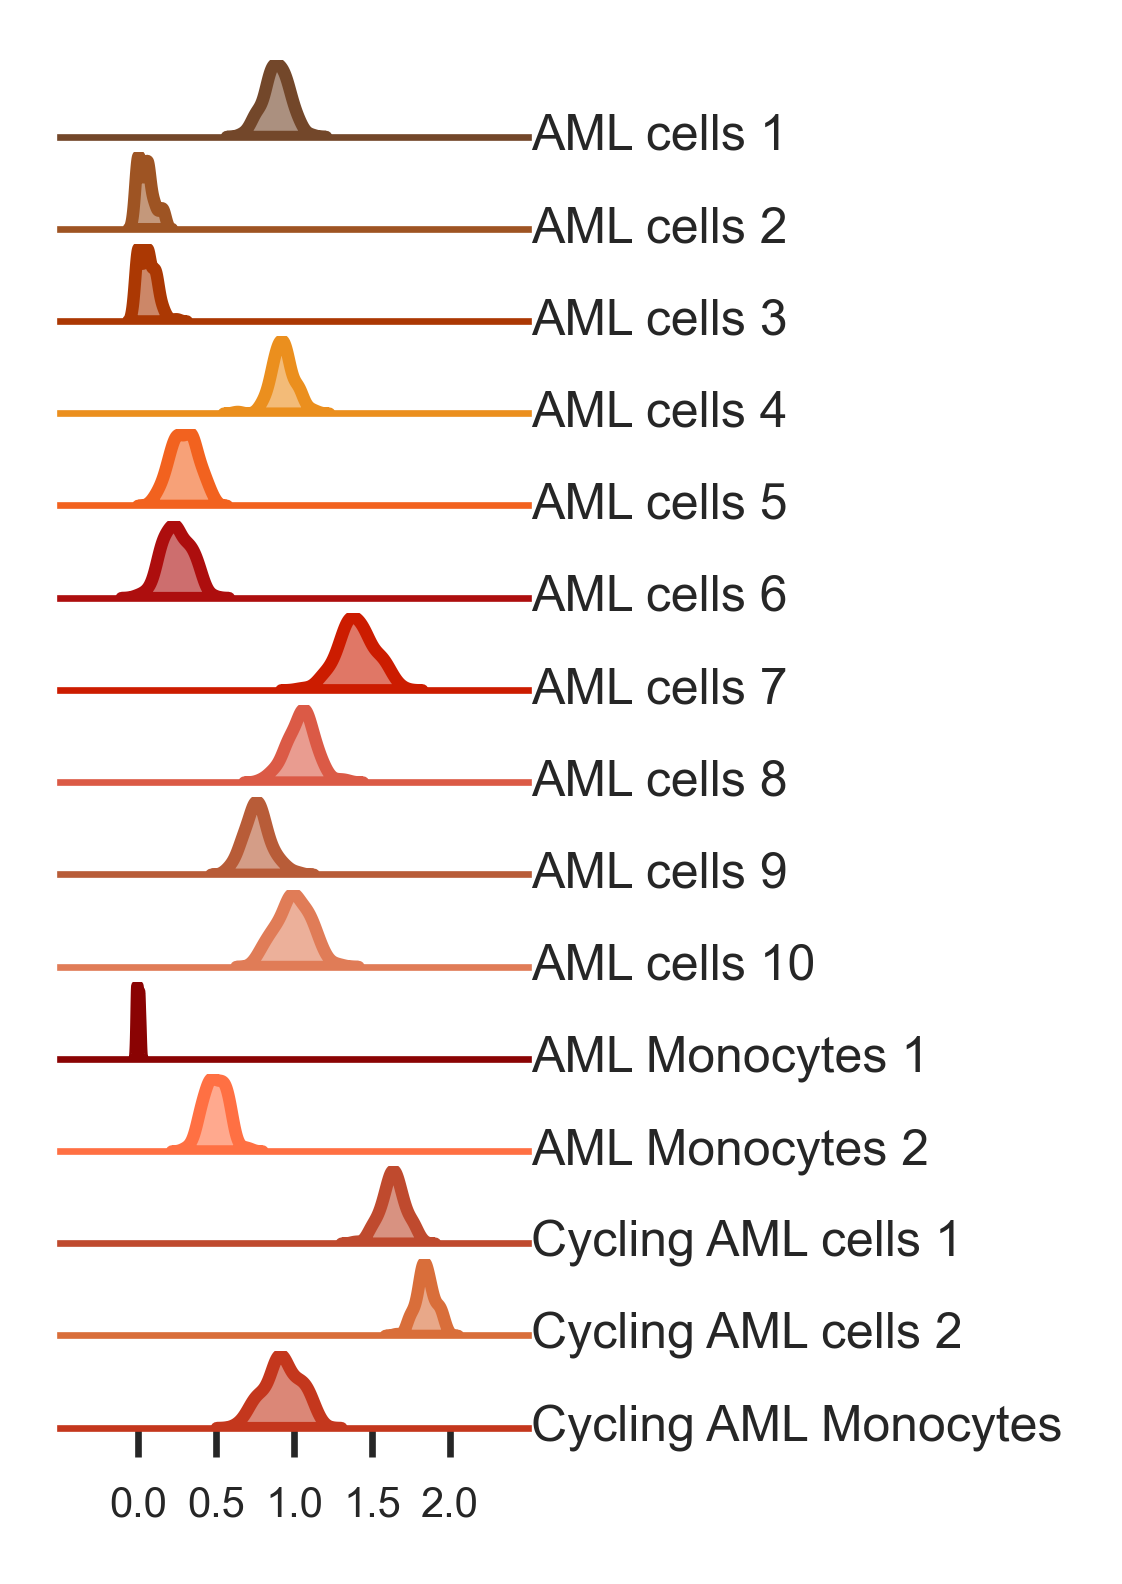

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PARAMETERS
ncells = 100  # number of cells to sample per cell type
nreps = 100   # number of repetitions for sampling
meta = 'cell_type_sub_prolif_anno'
sample_meta = 'code_renamed'

# SELECTED CELL TYPES
selected_cell_types = [
    "AML cells 1",
    "AML cells 2",
    "AML cells 3",
    "AML cells 4",
    "AML cells 5",
    "AML cells 6",
    "AML cells 7",
    "AML cells 8",
    "AML cells 9",
    "AML cells 10",
    "AML Monocytes 1",
    "AML Monocytes 2",
    "Cycling AML cells 1",
    "Cycling AML cells 2",
    "Cycling AML Monocytes"
]

# EXTRACT UNIQUE CELL TYPES (PRESERVE ORDER)
cell_types = [ct for ct in selected_cell_types if ct in adata.obs[meta].unique()]

# USE CUSTOM COLOR PALETTE
palette = cell_type_color_palette

# ENTROPY CALCULATION
H = pd.DataFrame()

for cell_type in cell_types:
    # SUBSET CELLS BY CELL TYPE
    cell_subset = adata[adata.obs[meta] == cell_type]

    H_sample = []

    for _ in range(nreps):
        # RANDOM SAMPLING
        sampled_cells = cell_subset[np.random.choice(cell_subset.shape[0], ncells, replace=True)]
        
        # COMPUTE PROBABILITIES
        labels = sampled_cells.obs[sample_meta]
        probs = labels.value_counts(normalize=True)
        
        # SHANNON ENTROPY
        entropy = -np.sum(probs * np.log(probs))
        H_sample.append(entropy)
    
    # HANDLE CASE WITH ZERO ENTROPY
    if all(h == 0 for h in H_sample):
        H_sample = np.random.normal(0.0, 0.01, nreps)  # Small normal distribution around 0.0

    # STORE RESULTS
    H = pd.concat([H, pd.DataFrame({'Entropy across patients': H_sample, 'Cell Type': [cell_type] * nreps})], ignore_index=True)

# DETERMINE GLOBAL X-AXIS LIMITS
x_min = -0.5  # Set fixed x-axis minimum
x_max = 2.5  # Set fixed x-axis maximum

# PLOT WITH SINGLE-COLUMN SUBPLOTS
num_plots = len(cell_types)
fig, axes = plt.subplots(num_plots, 1, figsize=(1, 3), sharex=False)

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable when only one plot

for i, cell_type in enumerate(cell_types):
    sns.kdeplot(data=H[H['Cell Type'] == cell_type]['Entropy across patients'], 
                fill=True, alpha=0.6, linewidth=1.5, color=palette[cell_type], ax=axes[i])
    axes[i].text(x_max + 0.02, 0, cell_type, fontsize=6, va='center')  # Add cell type on the right
    axes[i].set_xlim(x_min, x_max)  # Fixed x-axis limits from 0 to 2.5
    axes[i].spines['left'].set_visible(False)  # Completely remove Y-axis
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_color(palette[cell_type])  # Match X-axis color to density color
    axes[i].tick_params(axis='y', left=False, labelleft=False)  # Remove Y-axis ticks
    axes[i].set_yticks([])  # Remove Y-axis ticks completely
    axes[i].set_ylabel("")  # Remove Y-axis label
    axes[i].spines['left'].set_color('none')  # Ensure Y-axis is completely invisible

    # For all but the bottom plot, remove x-axis tick labels and ticks
    if i < num_plots - 1:
         axes[i].set_xticklabels([])
         axes[i].tick_params(axis='x', bottom=False, labelbottom=False)
         axes[i].set_xlabel("")
    else:
         # Set fixed x-ticks only on the bottom plot
         axes[i].set_xticks([0, 0.5, 1, 1.5, 2])
         axes[i].tick_params(axis='x', labelsize=5, bottom=True, labelbottom=True)
         axes[i].set_xlabel("")

    
    #axes[i].set_xticks([0, 0.5, 1, 1.5, 2])  # Set fixed x-ticks at 0 and 2.5
    #axes[i].set_xlabel("")
    #axes[i].tick_params(axis='x', labelsize=5, bottom=True, labelbottom=True)  # Set x-axis tick font size to 6 ## was 6

plt.tight_layout()
sns.despine()

# SAVE FIGURE
plt.savefig("figures/final/patient_entropy_distribution_aml_cells_and_aml_monocytes_v4.pdf", transparent=True, bbox_inches="tight")
plt.show()
